# Compare Navy Images using ImageNet

## Imports

In [1]:
%load_ext autoreload
%autoreload 2

import warnings
warnings.simplefilter('ignore')

In [2]:
%matplotlib inline  

import imp
import numpy as np
import os

import keras
import keras.backend
import keras.models

import innvestigate
import innvestigate.applications.imagenet
import innvestigate.utils as iutils

# Use utility libraries to focus on relevant iNNvestigate routines.
eutils = imp.load_source("utils", "../utils.py")
imgnetutils = imp.load_source("utils_imagenet", "../utils_imagenet.py")

# We create many graphs, let's not run out of memory.
if keras.backend.backend() == "tensorflow":
    config = keras.backend.tf.ConfigProto()
    config.gpu_options.allow_growth = True
    keras.backend.set_session(keras.backend.tf.Session(config=config))

Using TensorFlow backend.


## Models, data and analyzers

We choose a set of ImageNet models:

In [3]:
# Choose a list of models
netnames = ["vgg16",
            "resnet50",
            "inception_v3",
            "densenet121"]           
n_nets = len(netnames)

The following function will load a specific model, load the data in the respective format and create analyzers for this model.

**For a better understanding of this part we refer to the [Comparing networks on ImagenNet](imagenet_network_comparison.ipynb) notebook, from which this code segment is adopted from.**

In [4]:
def prepare_model_data_and_analyzers(netname):
    # Load the model definition.
    tmp = getattr(innvestigate.applications.imagenet, netname)
    net = tmp(load_weights=True, load_patterns="relu")

    # Build the model.
    model = keras.models.Model(inputs=net["in"], outputs=net["sm_out"])
    model.compile(optimizer="adam", loss="categorical_crossentropy")

    # Handle input depending on model and backend.
    channels_first = keras.backend.image_data_format() == "channels_first"
    color_conversion = "BGRtoRGB" if net["color_coding"] == "BGR" else None

    # Get some example test set images.
    images, label_to_class_name = eutils.get_imagenet_data(net["image_shape"][0])
    if not len(images):
        raise Exception("Please download the example images using: "
                        "'innvestigate/examples/images/wget_imagenet_2011_samples.sh'")

    patterns = net["patterns"]
    input_range = net["input_range"]

    noise_scale = (input_range[1]-input_range[0]) * 0.1

    # Methods we use and some properties.
    methods = [
        # NAME                    OPT.PARAMS                POSTPROC FXN                TITLE
        # Show input.
        ("input",                 {},                       imgnetutils.image,         "Input"),

        # Function
        ("gradient",              {"postprocess": "abs"},   imgnetutils.graymap,       "Gradient"),
        ("smoothgrad",            {"augment_by_n": 16,
                                   "noise_scale": noise_scale,
                                   "postprocess": "square"},imgnetutils.graymap,       "SmoothGrad"),

        # Signal
        ("deconvnet",             {},                       imgnetutils.bk_proj,       "Deconvnet"),
        ("guided_backprop",       {},                       imgnetutils.bk_proj,       "Guided Backprop",),
        ("pattern.net",           {"patterns": patterns},   imgnetutils.bk_proj,       "PatternNet"),

        # Interaction
        ("pattern.attribution",   {"patterns": patterns},   imgnetutils.heatmap,       "PatternAttribution"),
        ("deep_taylor.bounded",   {"low": input_range[0],
                                   "high": input_range[1]}, imgnetutils.heatmap,       "DeepTaylor"),
        ("input_t_gradient",      {},                       imgnetutils.heatmap,       "Input * Gradient"),
        ("integrated_gradients",  {"reference_inputs": input_range[0],
                                   "steps": 16},            imgnetutils.heatmap,       "Integrated Gradients"),
        ("lrp.z",                 {},                       imgnetutils.heatmap,       "LRP-Z"),
        ("lrp.epsilon",           {"epsilon": 1},           imgnetutils.heatmap,       "LRP-Epsilon"),
        ("lrp.sequential_preset_a_flat",{"epsilon": 1},     imgnetutils.heatmap,       "LRP-PresetAFlat"),
        ("lrp.sequential_preset_b_flat",{"epsilon": 1},     imgnetutils.heatmap,       "LRP-PresetBFlat"),
    ]
    
    # Create model without trailing softmax
    model_wo_softmax = iutils.keras.graph.model_wo_softmax(model)

    # Create analyzers.
    analyzers = []
    for method in methods:
        try:
            analyzer = innvestigate.create_analyzer(method[0],        # analysis method identifier
                                                    model_wo_softmax, # model without softmax output
                                                    **method[1])      # optional analysis parameters
        except innvestigate.NotAnalyzeableModelException:
            # Not all methods work with all models.
            analyzer = None
        analyzers.append(analyzer)
        
    return (net, color_conversion, channels_first, images, label_to_class_name,
            methods, model, model_wo_softmax, analyzers,)

## Analysis

Now we analyze each image with the different networks and different analyzers:

In [5]:
analyses = {}
texts = {}
    
for netname in netnames:
    print("Creating analyses for network {}.".format(netname))
    tmp = prepare_model_data_and_analyzers(netname)
    (net, color_conversion, channels_first, images, label_to_class_name,
     methods, model, model_wo_softmax, analyzers) = tmp

    analysis = np.zeros([len(images), len(analyzers)]+net["image_shape"]+[3])
    text = []
    print('images', len(images))
    for i, (x, y) in enumerate(images):
        # Add batch axis.
        x = x[None, :, :, :]
        x_pp = imgnetutils.preprocess(x, net)

        # Predict final activations, probabilites, and label.
        presm = model_wo_softmax.predict_on_batch(x_pp)[0]
        prob = model.predict_on_batch(x_pp)[0]
        y_hat = prob.argmax()

        # Save prediction info:
        print('label_to_class_name[y]',y)
        text.append(("%s" % label_to_class_name[y],    # ground truth label
                     "%.2f" % presm.max(),             # pre-softmax logits
                     "%.2f" % prob.max(),              # probabilistic softmax output  
                     "%s" % label_to_class_name[y_hat] # predicted label
                    ))

        for aidx, analyzer in enumerate(analyzers):
            if methods[aidx][0] == "input":
                # Do not analyze, but keep not preprocessed input.
                a = x / 255
            elif analyzer:
                # Analyze.
                a = analyzer.analyze(x_pp)

                # Apply common postprocessing, e.g., re-ordering the channels for plotting.
                a = imgnetutils.postprocess(a, color_conversion, channels_first)
                # Apply analysis postprocessing, e.g., creating a heatmap.
                a = methods[aidx][2](a)
            else:
                a = np.zeros_like(x)
            # Store the analysis.
            analysis[i, aidx] = a[0]

        analyses[netname] = analysis
        texts[netname] = text

Creating analyses for network vgg16.
Instructions for updating:
Colocations handled automatically by placer.
images 2
label_to_class_name[y] 429
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
label_to_class_name[y] 429
Creating analyses for network resnet50.
images 2
label_to_class_name[y] 429
label_to_class_name[y] 429
Creating analyses for network inception_v3.
images 2
label_to_class_name[y] 429
label_to_class_name[y] 429
Creating analyses for network densenet121.
images 2
label_to_class_name[y] 429
label_to_class_name[y] 429


Next, we visualize the analysis results:

Image nr. 0, true label: baseball


<Figure size 432x288 with 0 Axes>

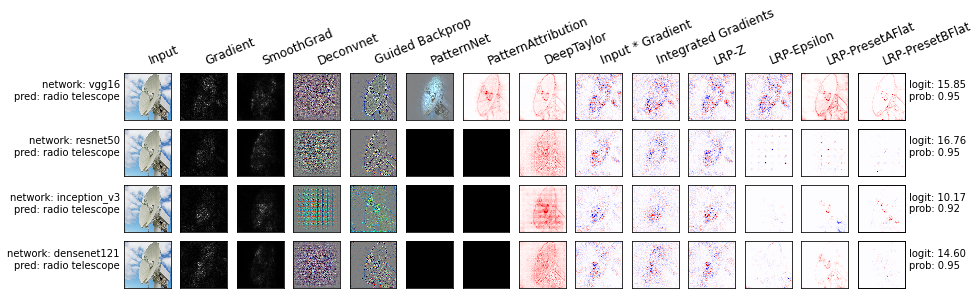

Image nr. 1, true label: baseball


<Figure size 432x288 with 0 Axes>

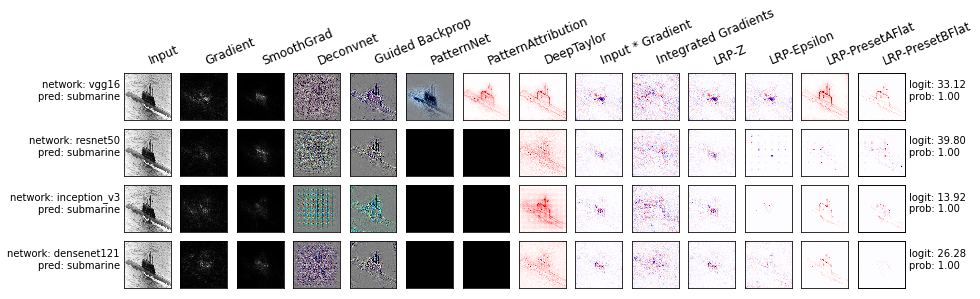

In [6]:
n_images = analyses[netnames[0]].shape[0]

# Prepare common labels
col_labels = [''.join(method[3]) for method in methods]

for image_index in range(n_images):
    grid = []
    row_labels_left = []
    row_labels_right = []
    
    for netname in netnames:
        analysis, text = analyses[netname], texts[netname]
        # Prepare the grid as rectengular list
        grid.append([analysis[image_index, j] for j in range(analysis.shape[1])])
        # Prepare the labels
        label, presm, prob, pred = zip(*text)
        label = label[image_index]
        row_labels_left.append(('network: {}'.format(netname),'pred: {}'.format(pred[image_index])))
        row_labels_right.append(('logit: {}'.format(presm[image_index]),'prob: {}'.format(prob[image_index])))

    # Plot the analysis.
    print("Image nr. {}, true label: {}".format(image_index, label))
    eutils.plot_image_grid(grid, row_labels_left, row_labels_right, col_labels,
                           file_name=os.environ.get("plot_file_name", None))

This figures show the analysis regarding the *actually predicted* class as computed by the selected analyzers. Each column shows the visualized results for different analyzers and each row shows the analyses wrt to one input sample. To the left of each row, the ground truth label `label` and the predicted label `pred` are show. To the right, the model's probabilistic (softmax) output is shown as `prob` and the logit output just before the terminating softmax layer as `logit`. Note that all analyses have been performed based on the logit output (layer).